# CounterVectorizer, TF-IDF

## Data download on web

In [1]:
#wget 명령어: HTTP, HTTPS, FTP 프로토콜을 이용해 웹서버에서 파일을 다운로드
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -zxf aclImdb_v1.tar.gz

--2023-03-20 11:16:44--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz.4’

aclImdb_v1.tar.gz.4 100%[===================>]  80.23M  10.0MB/s    in 10s     

2023-03-20 11:16:54 (8.01 MB/s) - ‘aclImdb_v1.tar.gz.4’ saved [84125825/84125825]



# Binary classification 문제
### IMDB review data with binary sentiment label(Pos=1,Neg=0)
Train_data 25000

Test_data 25000

In [2]:
import re
from pathlib import Path

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

/home/wooseok/miniconda3/envs/pplm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Dataset(object):
    
    max_features = 30000
    
    def __init__(self, split='train', vectorizer=None):
        self.split = split
        self.vectorizer = vectorizer
        
        self.data_list, self.label_list = self.load_data()
        
    def load_data(self):
        text_list = []
        label_list = []
        
        # POSITIVE DATA
        for path in Path(f'./aclImdb/{self.split}/pos/').glob('*'):
            with open(path) as f:
                text = f.readline()
                text_list.append(text)
                label_list.append(1)
        
        #NEGATIVE DATA
        for path in Path(f'./aclImdb/{self.split}/neg/').glob('*'):
            with open(path) as f:
                text = f.readline()
                text_list.append(text)
                label_list.append(0)
        '''
        CountVectorize
        문서를 토큰 리스트로 변환한다.
        각 문서에서 토큰의 출현 빈도를 센다.
        각 문서를 BOW 인코딩 벡터로 변환한다.(vocab에 있는 단어들로 BOW만듬. BOW란 
        Bag of Words란 단어들의 순서는 전혀 고려하지 않고, 단어들의 출현 빈도(frequency)에만 
        집중하는 텍스트 데이터의 수치화 표현 방법)
        '''
        if self.vectorizer is None:
            #self.vectorizer = CountVectorizer(max_features=self.max_features)
            self.vectorizer = TfidfVectorizer(max_features=self.max_features) # 다른 단어의 빈돗수도 고려해서 적용한것. 
            self.vectorizer.fit(text_list)
        data_list = self.vectorizer.transform(text_list).toarray()
        
        return data_list, label_list
        
    def __len__(self):
        return len(self.label_list)
    
    def __getitem__(self, index):
        data = torch.tensor(self.data_list[index], dtype=torch.float32)
        label = torch.tensor(self.label_list[index], dtype=torch.float32)
        return data, label

In [3]:
class Model(nn.Module):
    
    def __init__(self, max_features):
        super(Model, self).__init__()
        
        self.max_features = max_features
        self.dropout = nn.Dropout(p=0.1)
        self.linear1 = nn.Linear(self.max_features, 1)
        self.linear2 = nn.Linear(64, 32)
        self.linear3 = nn.Linear(512, 1)
        self.batchnorm1 = nn.BatchNorm1d(32)
        self.batchnorm2 = nn.BatchNorm1d(32)
        self.sigmid = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.LeakyRelu = nn.LeakyReLU()
        
    def forward(self, x):
        x = self.relu(self.linear1(x))
        #x = self.batchnorm1(x)
        #x = self.dropout(x)
        #x = self.relu(self.linear3(x))
        y = self.sigmid(x)
        return y

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 64
n_epochs = 50
lr = 0.01

In [35]:
device

'cuda'

In [6]:
train_ds = Dataset(split='train')
test_ds = Dataset(split='test', vectorizer=train_ds.vectorizer)

In [7]:
print(len(train_ds))
print(len(test_ds))

25000
25000


In [ ]:
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [13]:
print(len(train_dl))
print(len(test_dl))

391
391


TypeError: 'DataLoader' object is not subscriptable

In [14]:
model = Model(max_features=train_ds.max_features).to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [15]:
data,label = next(iter(train_dl))
data.shape

torch.Size([64, 30000])

In [26]:
data[1]

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [25]:
64*391

25024

In [19]:
import numpy as np
history = {'train_acc': [], 'test_acc': []}

for epoch in tqdm(range(n_epochs)):
    
    # train step
    train_acc = 0.0
    train_n_samples = 0
    
    model.train()
    for batch in train_dl:
        optimizer.zero_grad()
        
        x, y_true = map(lambda x: x.to(device), batch) # map(함수, 리스트)
        #print(x.shape)
        y_pred = model(x)
        
        loss = loss_fn(y_pred.view_as(y_true), y_true)
        loss.backward()
        
        optimizer.step()
        
        train_acc += torch.sum(torch.round(y_pred.view_as(y_true)) == y_true).item() # view_as() : y_pred를 y_true 모양대로 다시 정렬한다.
        train_n_samples += len(y_true)
    
    train_acc = (train_acc / train_n_samples) * 100.
    
    # test step
    if (epoch + 1) % 10 == 0:
        test_acc = 0.0
        test_n_samples = 0

        model.eval()
        for batch in test_dl:
            x, y_true = map(lambda x: x.to(device), batch)

            with torch.no_grad():
                y_pred = model(x)
                
            test_acc += torch.sum(torch.round(y_pred.view_as(y_true)) == y_true).item()
            test_n_samples += len(y_true)

        test_acc = (test_acc / test_n_samples) * 100.
        
        history['test_acc'].append(test_acc)
        history['train_acc'].append(train_acc)

        print(f'Epoch {epoch + 1} : Test_Accuracy = {test_acc:.3f}%')

 20%|██        | 10/50 [00:25<02:00,  3.01s/it]

Epoch 10 : Test_Accuracy = 82.060%


 40%|████      | 20/50 [00:51<01:30,  3.01s/it]

Epoch 20 : Test_Accuracy = 81.976%


 60%|██████    | 30/50 [01:17<01:00,  3.02s/it]

Epoch 30 : Test_Accuracy = 82.580%


 80%|████████  | 40/50 [01:43<00:30,  3.01s/it]

Epoch 40 : Test_Accuracy = 82.536%


100%|██████████| 50/50 [02:09<00:00,  2.59s/it]

Epoch 50 : Test_Accuracy = 82.728%


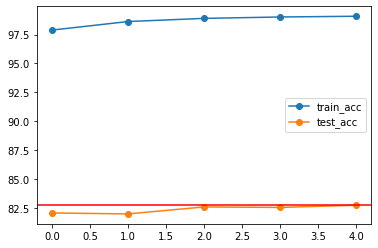

In [20]:
for key, value in history.items():
    plt.plot(value, '-o', label=key)
    
plt.axhline(max(history['test_acc']), color='r')
plt.legend()
plt.show()

# BERT Fintuning 

## 1.DATA

In [3]:
import re
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

torch.manual_seed(14)  # 랜덤 시드 고정

In [4]:
#wget 명령어: HTTP, HTTPS, FTP 프로토콜을 이용해 웹서버에서 파일을 다운로드
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -zxf aclImdb_v1.tar.gz

--2023-03-20 11:38:03--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz.7’

aclImdb_v1.tar.gz.7 100%[===================>]  80.23M  10.8MB/s    in 11s     

2023-03-20 11:38:14 (7.54 MB/s) - ‘aclImdb_v1.tar.gz.7’ saved [84125825/84125825]



In [5]:
class Dataset(object): 
    def __init__(self, split ='train'):
        self.split = split        
        self.data_list , self.label_list = self.load_data()
    
    def load_data(self):
        text_list = []
        label_list = []
        
        for path in list(Path(f'./aclImdb/{self.split}/pos/').glob('*')):
            with open(path) as f:
                text = f.readline()
                text_list.append(text)
                label_list.append(1)
                
        for path in list(Path(f'./aclImdb/{self.split}/neg/').glob('*')):
            with open(path) as f:
                text = f.readline()
                text_list.append(text)
                label_list.append(0)
        
        data_list = text_list
        
        return data_list, label_list 
    
    def __len__(self):
        return len(self.label_list)
    
    def __getitem__(self, index):
        data = self.data_list[index]
        label = torch.tensor(self.label_list[index], dtype = torch.long)
        return data, label

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'
batch_size = 4

In [7]:
train_ds = Dataset(split = 'train')
test_ds = Dataset(split='test')

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

#test
data, label= next(iter(train_dl))
#print(np.array(data).shape)
#print(label.shape)

In [8]:
data

('I really hate most end of the world movies. They show what jaded Hollywood people think of the rest of the world, and they clearly think we\'re a bunch of sadistic idiots (or at least that watching sadistic idiots react to things is somehow entertaining). I\'ve been to L.A. many times, I have family that works in show business, and I just want to say that these are the *last* people we should be looking to for a reality check. Some disaster movies at least paint a clever picture: Children of Men, 12 Monkeys, but usually the message is just "people will do anything to survive, all is dark and sad and purposeless, we should all be ashamed of ourselves".<br /><br />Don\'t get me wrong, I like the idea of a story that explores throwing off the system of social order and testing people\'s mettle in the face of horror, and I do believe some people would act like this film portrayed, but sadistic idiots aside, I seriously doubt society would just dissolve into every man for himself, that\'s

In [9]:
label

tensor([0, 1, 1, 1])

## 2.0. 잠시 버트 공부
- BERT 위에 해당 task를 위한 추가적인 layer를 쌓는다.-> 쌓은 추가 layer를 head라고 부름
- BertModel : head가 없는 순수 BERT

In [18]:
# 확인
model = BertModel.from_pretrained("bert-base-uncased",
                                  add_pooling_layer=False, 
                                  output_hidden_states=True, 
                                  output_attentions=True)
#print("model.num_parameters() : ",model.num_parameters())
#print(model)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [28]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
# 
model_input = tokenizer("I love nlp!") 
print(model_input)
model_input = tokenizer("I love nlp!", return_tensors = 'pt') 
print(model_input)

output = model(**model_input)

#print(output.keys())
print(output)

{'input_ids': [101, 1045, 2293, 17953, 2361, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}
{'input_ids': tensor([[  101,  1045,  2293, 17953,  2361,   999,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}
(tensor([[[ 0.2209,  0.1699,  0.0934,  ..., -0.1559,  0.0444,  0.4951],
         [ 0.3760,  0.0641,  0.3621,  ..., -0.3894,  0.3871,  0.2699],
         [ 1.2370,  0.6530,  0.6309,  ..., -0.2550,  0.2048,  0.2399],
         ...,
         [-0.0763, -0.3767,  0.5944,  ..., -0.0092, -0.2557, -0.2264],
         [-0.3802, -0.4716, -0.3021,  ...,  1.3402, -0.1371, -0.1826],
         [ 0.7695,  0.1139, -0.1194,  ..., -0.0619, -0.6581, -0.0691]]],
       grad_fn=<NativeLayerNormBackward>), None, (tensor([[[ 1.6855e-01, -2.8577e-01, -3.2613e-01,  ..., -2.7571e-02,
           3.8253e-02,  1.6400e-01],
         [-3.3999e-04,  5.3974e-01, -2.8805e-01,  ...,  7.5731e-01,
           8.9008e-

In [30]:
output[0]

tensor([[[ 0.2209,  0.1699,  0.0934,  ..., -0.1559,  0.0444,  0.4951],
         [ 0.3760,  0.0641,  0.3621,  ..., -0.3894,  0.3871,  0.2699],
         [ 1.2370,  0.6530,  0.6309,  ..., -0.2550,  0.2048,  0.2399],
         ...,
         [-0.0763, -0.3767,  0.5944,  ..., -0.0092, -0.2557, -0.2264],
         [-0.3802, -0.4716, -0.3021,  ...,  1.3402, -0.1371, -0.1826],
         [ 0.7695,  0.1139, -0.1194,  ..., -0.0619, -0.6581, -0.0691]]],
       grad_fn=<NativeLayerNormBackward>)

AutoTokenizer.from_pretrained() 메소드에 모델명을 입력하면 모델과 매치되는 tokenizer를 불러올 수 있다. 이를 이용해 bert-base-uncased 모델의 tokenizer를 불러오자.

In [33]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
# 
model_input = tokenizer("I love nlp!") 
print(model_input)
model_input = tokenizer("I love nlp!", return_tensors = 'pt') 
print(model_input)

output = model(**model_input,returen_dict = True)

print(output.keys())
print(output)

{'input_ids': [101, 1045, 2293, 17953, 2361, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}
{'input_ids': tensor([[  101,  1045,  2293, 17953,  2361,   999,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}


TypeError: forward() got an unexpected keyword argument 'returen_dict'

In [23]:
output

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.2209,  0.1699,  0.0934,  ..., -0.1559,  0.0444,  0.4951],
         [ 0.3760,  0.0641,  0.3621,  ..., -0.3894,  0.3871,  0.2699],
         [ 1.2370,  0.6530,  0.6309,  ..., -0.2550,  0.2048,  0.2399],
         ...,
         [-0.0763, -0.3767,  0.5944,  ..., -0.0092, -0.2557, -0.2264],
         [-0.3802, -0.4716, -0.3021,  ...,  1.3402, -0.1371, -0.1826],
         [ 0.7695,  0.1139, -0.1194,  ..., -0.0619, -0.6581, -0.0691]]],
       grad_fn=<NativeLayerNormBackward>), pooler_output=None, hidden_states=(tensor([[[ 1.6855e-01, -2.8577e-01, -3.2613e-01,  ..., -2.7571e-02,
           3.8253e-02,  1.6400e-01],
         [-3.3999e-04,  5.3974e-01, -2.8805e-01,  ...,  7.5731e-01,
           8.9008e-01,  1.6575e-01],
         [ 1.1558e+00,  8.5330e-02, -1.1208e-01,  ...,  4.3965e-01,
           8.5903e-01, -3.2685e-01],
         ...,
         [-2.5768e-01, -1.0146e-01,  6.2847e-01,  ...,  2.6420e-01,
          -3.7479e-0

In [24]:
# 
# output.last_hidden_state 값을 입력된 텍스트에 대해 BERT가 생성한 최종 embedding으로 여긴다.
# 이 embedding을 사용하여 downstream task를 수행한다.
print(output.last_hidden_state.shape)


print(len(output.hidden_states))
print(output.hidden_states[-1] == output.last_hidden_state)
print(output.hidden_states[0].shape)

torch.Size([1, 7, 768])
13
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]])
torch.Size([1, 7, 768])


In [21]:
print(output.last_hidden_state[:,0])
print(output.last_hidden_state[:,1])
print(output.last_hidden_state[:,2])

tensor([[ 2.2091e-01,  1.6989e-01,  9.3419e-02, -3.2108e-01, -3.6137e-01,
         -4.6729e-01,  4.0362e-01,  6.8455e-01, -3.2131e-02, -1.4123e-01,
         -8.1232e-02, -1.8916e-01,  1.0746e-01,  5.8316e-01,  2.0251e-01,
         -1.0945e-01, -2.6338e-01,  2.6269e-01,  2.8839e-01, -7.8587e-02,
         -1.2404e-01, -4.1189e-01, -1.2374e-01, -2.0354e-01, -5.0091e-02,
          7.0595e-02,  1.2426e-01, -9.9673e-02,  1.9350e-01, -1.4482e-01,
          5.7874e-02,  2.2919e-01, -2.9904e-01,  5.3409e-02,  1.0235e-01,
          3.9535e-02,  2.7970e-01,  2.4146e-01, -8.3068e-02,  2.7613e-02,
          1.9800e-01, -1.5508e-01,  8.9303e-02,  1.4289e-01, -1.7644e-01,
         -6.0106e-01, -2.5794e+00,  6.0887e-02, -1.7466e-01, -3.5588e-01,
          2.8755e-01,  2.3186e-01,  2.0950e-01,  9.2507e-02,  2.1709e-01,
          9.4828e-02, -5.2743e-01,  5.7870e-01, -1.8871e-01,  2.7259e-01,
          8.3475e-02,  6.5978e-02,  1.3859e-01,  2.0849e-01,  1.0249e-01,
         -1.3757e-01, -4.1835e-02,  4.

In [22]:
print(output.last_hidden_state)

tensor([[[ 0.2209,  0.1699,  0.0934,  ..., -0.1559,  0.0444,  0.4951],
         [ 0.3760,  0.0641,  0.3621,  ..., -0.3894,  0.3871,  0.2699],
         [ 1.2370,  0.6530,  0.6309,  ..., -0.2550,  0.2048,  0.2399],
         ...,
         [-0.0763, -0.3767,  0.5944,  ..., -0.0092, -0.2557, -0.2264],
         [-0.3802, -0.4716, -0.3021,  ...,  1.3402, -0.1371, -0.1826],
         [ 0.7695,  0.1139, -0.1194,  ..., -0.0619, -0.6581, -0.0691]]],
       grad_fn=<NativeLayerNormBackward0>)


# Model

In [10]:
from transformers import BertTokenizerFast, BertModel

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        #참고로 'bert-base-uncased' 모델은 버트의 가장 기본적인 모델을 의미
        #uncased는 모든 문장을 소문자로 대체하겠다는 것 
        
        self.classifier  = nn.Sequential(
            nn.ReLU(),
            nn.Linear(768,2)
        )
        
        
    def forward(self,inputs):
        
        #print(inputs['input_ids'].shape)  
        bert_outputs = self.bert(**inputs,return_dict =True)
        #print("bert_outputs",bert_outputs)
        pooler_output = bert_outputs.last_hidden_state[:,0]
        # bert_outputs.last_hidden_state[:,0] -> 첫번째니까 [cls] 토큰의
        # embedding만을 뽑아내어 classification task를 위한 텐서로 변환한다? 
        #print("pooler_output",pooler_output.shape)
        
        logits = self.classifier(pooler_output)
        #print("logits",logits.shape)
        
        return logits

In [ ]:

n_epochs = 10
lr = 1e-6

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
model = Model().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

history = {'train_acc': [], 'test_acc': []}

for epoch in range(n_epochs):
    
    print('Epoch', epoch + 1)
    
    # train step
    train_acc = 0.0
    train_n_samples = 0
    
    model.train()
    for batch in tqdm(train_dl, ncols=80, desc='train_step'):
        
        data, y_true = batch
        data = tokenizer(list(data), return_tensors='pt', padding=True, truncation=True)
        
        data = { k: v.to(device) for k, v in data.items() }
        y_true = y_true.to(device)
        
        optimizer.zero_grad()
        
        y_pred = model(data)
        
        loss = loss_fn(y_pred, y_true)
        loss.backward()
        
        optimizer.step()
    
        train_acc += torch.sum(y_pred.argmax(1) == y_true).item()
        train_n_samples += len(y_true)
    
    train_acc = (train_acc / train_n_samples) * 100.
    
    # test step
    if (epoch + 1) % 1 == 0:
        test_acc = 0.0
        test_n_samples = 0

        model.eval()
        for batch in tqdm(test_dl, ncols=80, desc='valid_step'):
            
            data, y_true = batch
            data = tokenizer(list(data), return_tensors='pt', padding=True, truncation=True)

            data = { k: v.to(device) for k, v in data.items() }
            y_true = y_true.to(device)
            
            with torch.no_grad():
                y_pred = model(data)
            
            test_acc += torch.sum(y_pred.argmax(1) == y_true).item()
            test_n_samples += len(y_true)

        test_acc = (test_acc / test_n_samples) * 100.
        if len(history['test_acc']) >0 :
            if max(history['test_acc']) < test_acc :
                torch.save(model, 'model.pt')
        history['test_acc'].append(test_acc)
        history['train_acc'].append(train_acc)

        print(f'Epoch {epoch + 1} : {test_acc:.3f}%')
for key, value in history.items():
    plt.plot(value, '-o', label=key)
    
plt.axhline(max(history['test_acc']), color='r')
plt.legend()
plt.show()

Epoch 1


valid_step: 100%|███████████████████████████| 6250/6250 [07:19<00:00, 14.22it/s]


Epoch 1 : 92.560%
Epoch 2


train_step:  32%|████████▋                  | 2008/6250 [07:29<14:15,  4.96it/s]

In [ ]:

model = torch.load('model.pt')

data =  ['not beautiful','fucking bad ','umm...  not bad ','wonderful, but uncomfortable','beautiful and comfortable and pretty','i was happy','i am beauti']data = tokenizer(data, return_tensors='pt', padding=True, truncation=True)
data = { k: v.to(device) for k, v in data.items() }

with torch.no_grad():
    y_pred = model(data)
y_pred.argmax(1)

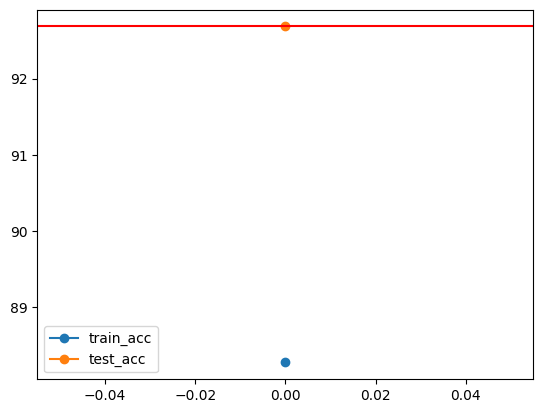